In [0]:
#Importing all the important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Using quandl for collecting data.
pip install quandl

  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [3]:
import quandl
mydata = quandl.get("AMFI/119894")
mydata.head()

,Net Asset Value,Repurchase Price,Sale Price
Date,,,
2013-01-02,12.34,None,None
2013-01-03,12.43,None,None
2013-01-04,12.42,None,None
2013-01-07,12.41,None,None
2013-01-08,12.43,None,None


In [0]:
mydata = mydata.drop(['Repurchase Price','Sale Price'],axis=1) 
#Since those columns don't have any data.

In [0]:
def create_features(df):
    """
    Creates time series features from datetime index, as we dont have any other data for feature engineering.
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [0]:
def split_data(data, split_date):
    """
    Function for Creating test and training data based on date.
    """
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

# **XGB Model**

>>>>>>![alt text](https://i.imgur.com/e7MIgXk.png)

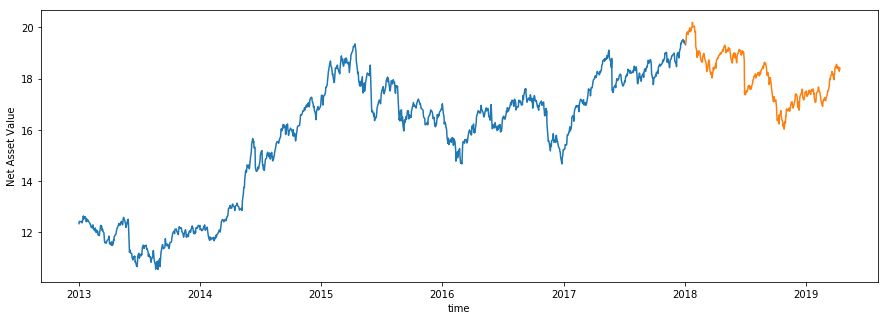

In [7]:
train, test = split_data(mydata, '02-Jan-2018')

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Net Asset Value')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()


In [8]:
X_train, y_train = create_features(train), train['Net Asset Value']
X_test, y_test   = create_features(test), test['Net Asset Value']
#assigning all the features extracted to test and training data
X_train.shape, y_train.shape

((1230, 8), (1230,))

In [0]:
#First model is the XGB.
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

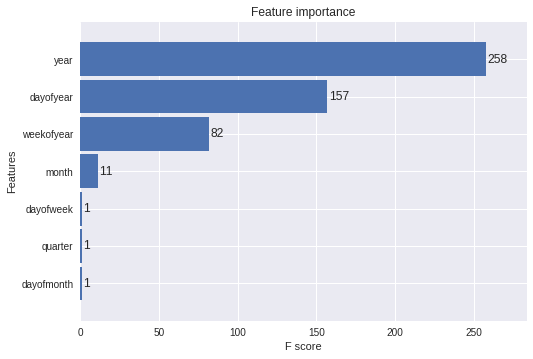

In [0]:
xgb.plot_importance(reg, height=0.9)
#Most important features, reflect the effect of daily and seasonal trend.

In [0]:
def plot_performance(base_data, date_from, date_to, title=None):
    """
    Function for getting the performance of the model between two dates.
    """
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('Net asset value')
    plt.plot(mydata.index,mydata, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

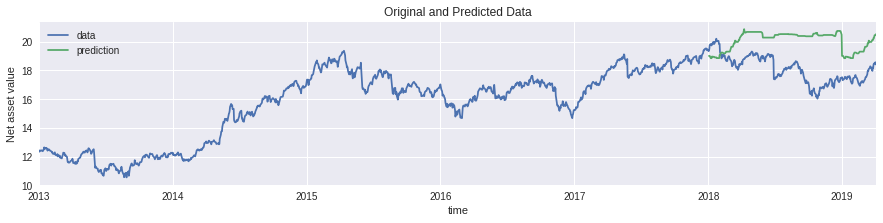

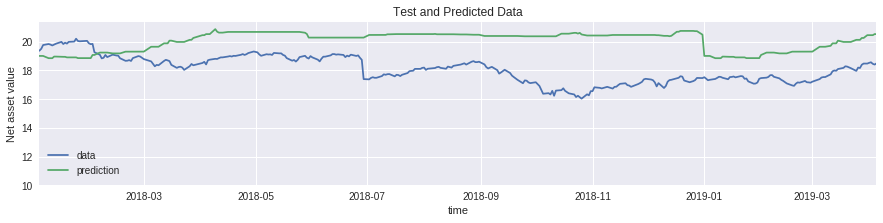

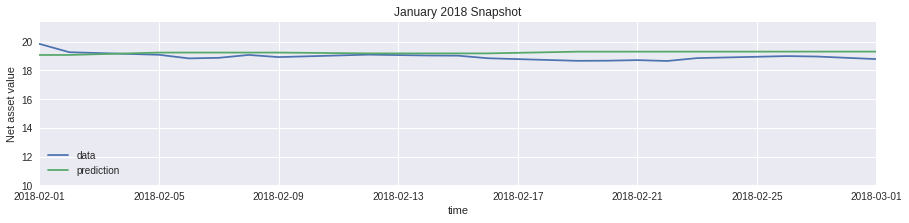

In [0]:
X_test_pred = reg.predict(X_test)
    
plot_performance(mydata, mydata.index[0].date(), mydata.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

plot_performance(y_test, '02-01-2018', '03-01-2018', 'January 2018 Snapshot')

plt.legend()

plt.show()

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
mean_absolute_percentage_error(y_test,X_test_pred)

11.794350843957236

In [0]:
mean_squared_error(y_true=y_test,y_pred=X_test_pred)

5.2972257705305825

In [0]:
mean_absolute_error(y_true=y_test,y_pred=X_test_pred)

2.0861748713159103

# **TPOT Model**

![alt text](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-ml-pipeline.png)

In [0]:
pip install tpot

In [0]:
#An amazing library which analysis data, selects the most important features and gives the best possible model in a given computation time.
from tpot import TPOTClassifier
from tpot import TPOTRegressor

tpot = TPOTRegressor(verbosity=2, max_time_mins=20, max_eval_time_mins=0.08, population_size=15) #Setting the computation time at 20mins

tpot.fit(X_train, y_train)

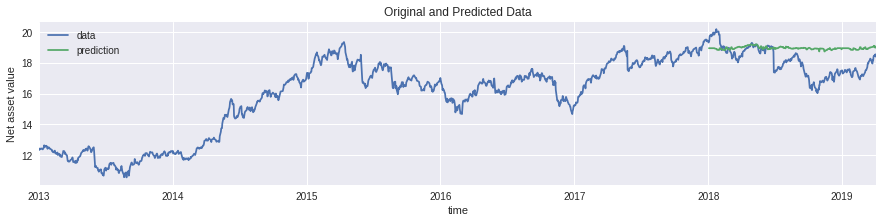

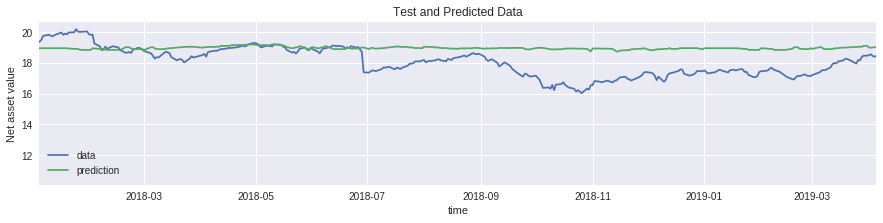

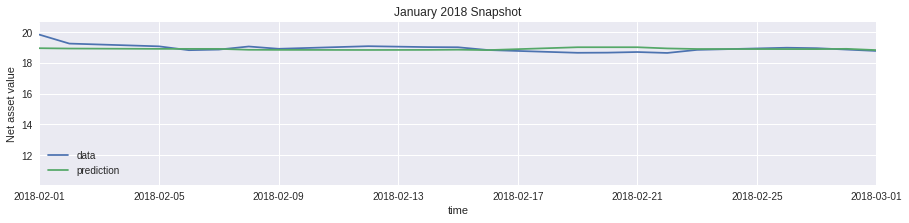

In [0]:
#Performance evaluation
X_test_pred = tpot.predict(X_test)
    
plot_performance(mydata, mydata.index[0].date(), mydata.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

plot_performance(y_test, '02-01-2018', '03-01-2018', 'January 2018 Snapshot')

plt.legend()

plt.show()

## **LSTM Model**

![alt text](https://cdn-images-1.medium.com/max/1600/1*O73nlRM3-bWubvt6W-1YSg.png)

In the conventional feed-forward neural networks, all test cases are considered to be independent. That is when fitting the model for a particular day, there is no consideration for the stock prices on the previous days.

This dependency on time is achieved via *Recurrent Neural Networks*. A typical RNN looks like:

>>>>>
![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/05231650/rnn-neuron-196x300.png)





Unlike RNN, LSTM models give 'importance' to particular feature in a given time frame. For ex, if a stock always spikes in the interval of 3 months it catches that and keeps that in mind while predicting future prices
As a result LSTM models tend to perform really well on time series dataset yet they deteriorate for very far predictions. So for **short intervals**, this performs really well.

In [0]:
def create_features2(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['date','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
df = create_features2(mydata)
df['NAV'] = mydata.iloc[:,0]
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'NAV'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['NAV'][i] = data['NAV'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=4, batch_size=1, verbose=2)

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)

Epoch 1/4
 - 48s - loss: 0.0037
Epoch 2/4
 - 46s - loss: 0.0012
Epoch 3/4
 - 46s - loss: 0.0010
Epoch 4/4
 - 46s - loss: 6.8392e-04


In [19]:
mean_squared_error(y_true=valid['NAV'],y_pred=valid['Predictions'])

0.048231509399037774

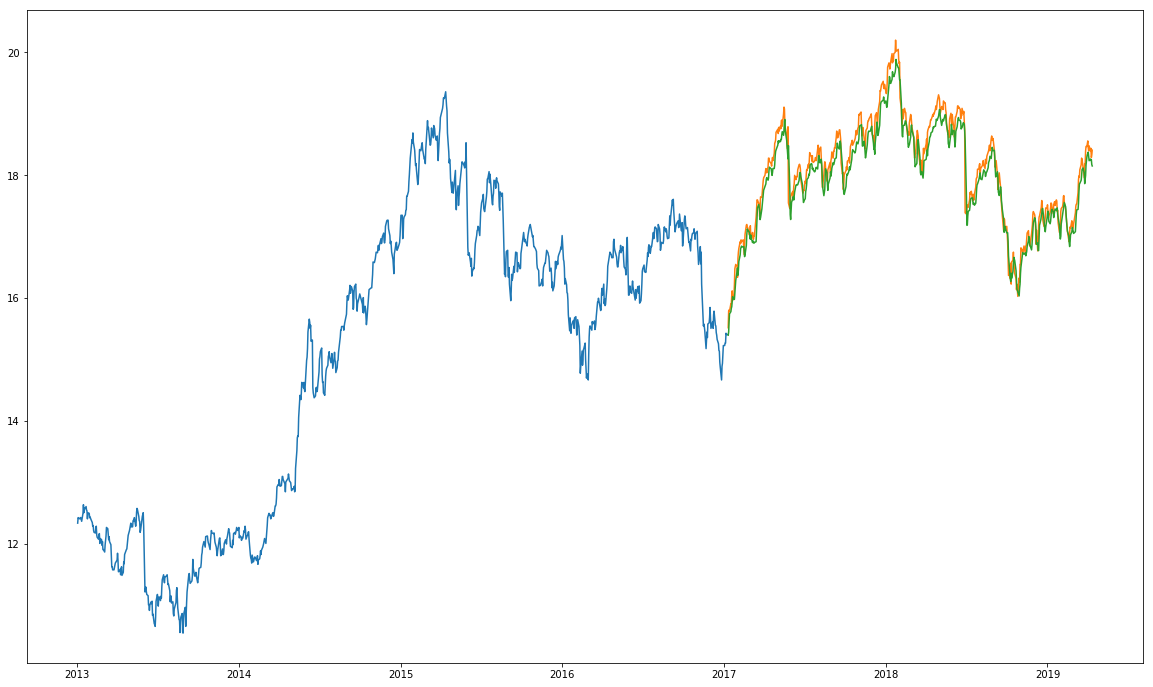

In [21]:
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = pred_price
plt.figure(figsize=(20,12))
plt.plot(train['NAV'])
plt.plot(valid[['NAV','Predictions']])

In [0]:
def plot_performance_lstm(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(20,6))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('Net asset value')
    plt.plot(train['NAV'])
    plt.plot(valid[['NAV','Predictions']])
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

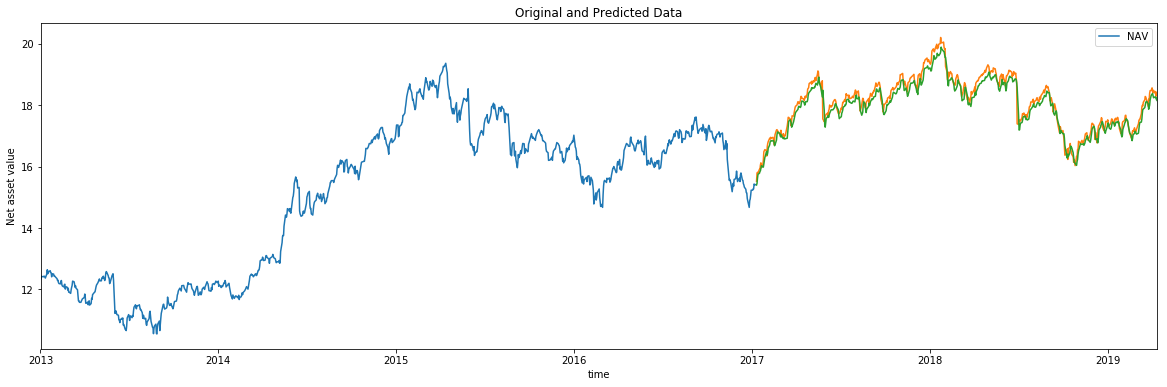

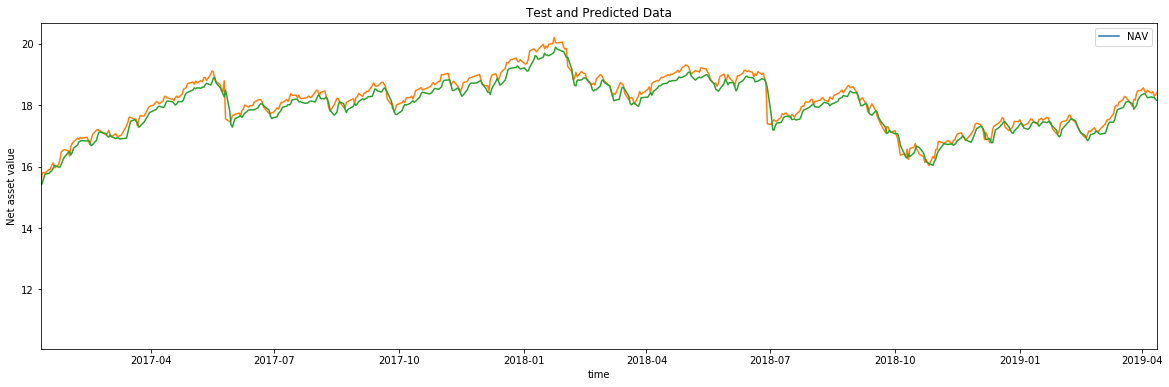

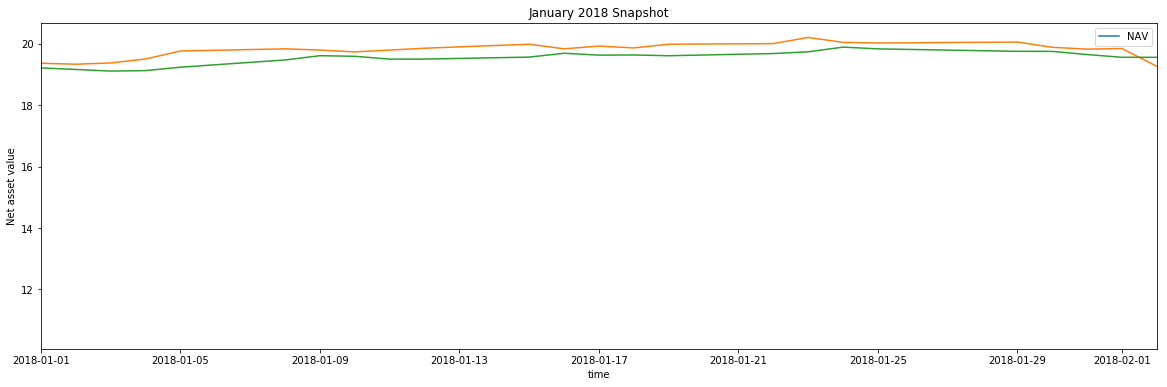

In [16]:
plot_performance_lstm(mydata, mydata.index[0].date(), mydata.index[-1].date(),
                 'Original and Predicted Data')

plot_performance_lstm(valid['Predictions'], valid['Predictions'].index[0].date(), valid['Predictions'].index[-1].date(),
                 'Test and Predicted Data')

plot_performance_lstm(valid['Predictions'], '01-01-2018', '02-02-2018', 'January 2018 Snapshot')

plt.legend()

plt.show()